<a href="https://colab.research.google.com/github/willyheng/python_quant/blob/main/cert_tutorial_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://hilpisch.com/tpq_logo.png" width="350px" align="right">

## TEST PROJECT SUBMISSION
### Willy Heng
### 27 Jun 2023

# Certificate Programs

**Tutorial 06**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

http://tpq.io | [training@tpq.io](mailto:trainin@tpq.io) | [@dyjh](http://twitter.com/dyjh)

## Test Project &mdash; Algorithmic Trading

**Prediction-based Trading & Event-based Backtesting**

Implement a class that uses **event-based backtesting** to backtest the following prediction-based strategy:

* Data from `http://hilpisch.com/ref_eikon_eod_data.csv`.
* Select one symbol from the data set.
* Create the following features:
    * log return
    * direction (up or down)
    * log return as 5 categories
    * two SMAs (short and long window)
    * difference between the SMAs
    * two EWMAs (short and long window)
    * difference between the EWMAs
    * two rolling volatilities (short and long window)
* Split the data set into training (70%) and testing data.
* Normalize the training features data to have
    * zero mean and
    * standard deviation of one.
* Normalize the test features data by the same moment values as the training data.
* Create lagged features data for 5 lags.
* Train and (back-)test the following algorithms for directional (long/short) trading (from `scikit-learn`):
    * `GaussianNB()`
    * `LogisticRegression()`
    * `DecisionTreeClassifier()`
    * `SVC()`
    * `MLPClassifier()`
* Compare the performance of the different models numerically.

For the implementation, you can rely e.g. on the Python classes as presented in the PyAlgo class sessions and the resources.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
class TradingBot:
    url = "http://hilpisch.com/ref_eikon_eod_data.csv"

    def __init__(self, sym, window_short, window_long):
        self.sym = sym
        self.window_short = window_short
        self.window_long = window_long

        self.X, self.y = self._prepare_data()

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = \
            self._train_test_split(self.X, self.y, 0.7)

        # Normalize
        self.X_train, self.X_test, self.std = \
            self._normalize_train_test(self.X_train, self.X_test)

        # Add lags
        self.X_train, self.y_train = self._add_lags(self.X_train, self.y_train)
        self.X_test, self.y_test = self._add_lags(self.X_test, self.y_test)

        # Models
        self.models = {'nb': GaussianNB(),
            'log': LogisticRegression(max_iter=100000),
            'dt': DecisionTreeClassifier(),
            'svc': SVC(),
            'mlp': MLPClassifier(hidden_layer_sizes=(50, 50, 30), max_iter=10000)
            }


    def _prepare_data(self):
        self.raw = pd.read_csv(self.url, parse_dates=True, index_col=0)
        df = self.raw[self.sym].rename("px").dropna().to_frame()
        df['log_ret'] = np.log(df['px'] / df['px'].shift(1))
        df['dir'] = np.sign(df['log_ret'])
        df['log_ret_cat'] = pd.cut(df['log_ret'], bins=5, labels=False)
        df['sma_short'] = df['px'].rolling(self.window_short).mean()
        df['sma_long'] = df['px'].rolling(self.window_long).mean()
        df['sma_diff'] = df['sma_short'] - df['sma_long']
        df['ewma_short'] = df['px'].ewm(span=self.window_short, adjust=False).mean()
        df['ewma_long'] = df['px'].ewm(span=self.window_long, adjust=False).mean()
        df['ewma_diff'] = df['ewma_short'] - df['ewma_long']
        df['vol_short'] = df['log_ret'].rolling(self.window_short).std()
        df['vol_long'] = df['log_ret'].rolling(self.window_long).std()

        df = df.drop('px', axis=1)
        df = df.dropna()

        return df, df['log_ret'].shift(-1)

    def _train_test_split(self, X, y, train_ratio, shuffle=False):
        return train_test_split(X, y, train_size=train_ratio, shuffle=shuffle)

    def _normalize_train_test(self, X_train, X_test):
        std = StandardScaler()
        X_train_std = pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)
        X_test_std = pd.DataFrame(std.transform(X_test), columns=X_test.columns)

        return X_train_std, X_test_std, std

    def _add_lags(self, X, y, n_lags = 5):
        results = pd.concat([X] + [X.shift(n).add_suffix(f'_lag{n}') for n in range(1, n_lags + 1)], axis=1)
        valid = ~results.isna().any(axis=1).values

        return results[valid], y[valid]

    def backtest(self, model, return_ts=False, annualize=True):
        X_train, y_train, X_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test
        #model.fit(X_train_lag, np.sign(y_train_lag))
        # Train categorically
        model.fit(X_train, (y_train > 0)*1)

        pred_train = (model.predict(X_train) * 2 - 1)
        pred_test = (model.predict(X_test) * 2 - 1)

        perf_train = (pred_train * y_train)
        perf_test = (pred_test * y_test)
        if return_ts:
            return pred_train, pred_test, perf_train, perf_test

        if annualize:
            return perf_train.mean() * 252, perf_test.mean() * 252
        return perf_train.mean(), perf_test.mean()

    def backtest_all(self):
        return pd.DataFrame({k: pd.Series(self.backtest(m), index=['train', 'test']) for k, m in self.models.items()})

In [3]:
bot = TradingBot('.SPX', 50, 300)
returns = bot.backtest_all()

<Axes: title={'center': 'Annualized log returns of strategy'}>

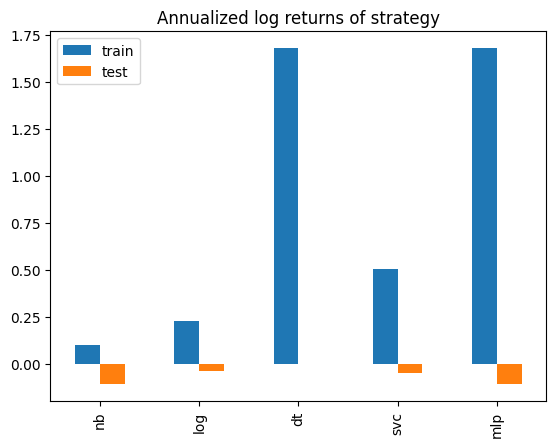

In [4]:
returns.T.plot(kind='bar', title="Annualized log returns of strategy")

# Generally good returns for train set, but poor returns for test set for these models.
# Which is a sign of heavy over fitting. Some form of regularization or dropout could help
# Naive Bayes and Logistic Regression could not fit well even on training set

## Test Project &mdash; Computational Finance

**Complete Market Models & Pricing Library**

Write a pricing library for European plain vanilla and exotic options making use of geometric Brownian motion as the stochastic process. The pricing shall be based on Monte Carlo simulation.

The pricing library shall have:

* a class for the risk-neutral discounting (taking the short rate as parameter, generating discount factors as required, etc.)
* a class to model the parameters of the underyling risk factor and a European option (initial value, volatility, time-to-maturity, dividends, strike price, option type etc.)
* a class to value European **vanilla options** based on Monte Carlo simulation
* a class to value European **lookback options** &mdash; with either fixed or floating strike (see https://en.wikipedia.org/wiki/Lookback_option)
* a class to value European **Asian options** &mdash; with either fixed price or fixed strike (see https://en.wikipedia.org/wiki/Asian_option)

In [5]:
class RiskNeutralDiscounting:
    def __init__(self, short_rate):
        self.short_rate = short_rate

    def discount_factor(self, time_to_maturity):
        #periods = np.arange(0, time_to_maturity+1/253, 1/252)
        #return np.exp(-self.short_rate * periods)
        return np.exp(-self.short_rate * time_to_maturity)

class EuropeanOption(RiskNeutralDiscounting):
    def __init__(self, short_rate, initial_value, volatility, time_to_maturity, dividends, option_type, strike_px=None):
        super().__init__(short_rate)
        self.initial_value = initial_value
        self.volatility = volatility
        self.time_to_maturity = time_to_maturity
        self.dividends = dividends
        self.strike_px = strike_px
        self.option_type = option_type.lower()

    def gbm(self):
        n = 252 * self.time_to_maturity
        T = self.time_to_maturity
        dt = T / n

        asset_path = np.exp( \
            (self.short_rate - self.volatility**2/2) * dt + \
                self.volatility * np.random.normal(0, np.sqrt(dt), size=(n)))
        return self.initial_value * asset_path.cumprod()

class VanillaOption(EuropeanOption):
    def calc_price(self, n_sims=10000):
        paths = np.array([self.gbm() for i in range(n_sims)])

        if self.option_type == 'call':
            val = np.maximum(paths[:, -1] - self.strike_px, 0)

        elif self.option_type == 'put':
            val = np.maximum(-paths[:, -1] + self.strike_px, 0)

        discounted_val = val * self.discount_factor(self.time_to_maturity)

        return np.mean(discounted_val)

class LookbackOption(EuropeanOption):
    def __init__(self, is_fixed, *args, **argsv):
        super().__init__(*args, **argsv)
        self.is_fixed = is_fixed

    def calc_price(self, n_sims=10000):
        paths = np.array([self.gbm() for i in range(n_sims)])
        if self.is_fixed:
            if self.option_type == 'call':
                val = np.maximum(np.max(paths, axis=1) - self.strike_px, 0)

            elif self.option_type == 'put':
                val = np.maximum(-np.min(paths, axis=1) + self.strike_px, 0)

        else: # Floating
            if self.option_type == 'call':
                val = np.maximum(paths[:, -1] - np.min(paths, axis=1), 0)

            elif self.option_type == 'put':
                val = np.maximum(np.max(paths, axis=1) - paths[:, -1], 0)

        discounted_val = val * self.discount_factor(self.time_to_maturity)

        return np.mean(discounted_val)

class AsianOption(EuropeanOption):
    def __init__(self, is_fixed, *args, **argsv):
        super().__init__(*args, **argsv)
        self.is_fixed = is_fixed

    def calc_price(self, n_sims=10000):
        paths = np.array([self.gbm() for i in range(n_sims)])
        mean_paths = np.mean(paths, axis=1)
        if self.is_fixed:
            if self.option_type == 'call':
                val = np.maximum(mean_paths - self.strike_px, 0)

            elif self.option_type == 'put':
                val = np.maximum(-mean_paths + self.strike_px, 0)

        else: # Floating
            if self.option_type == 'call':
                val = np.maximum(paths[:, -1] - mean_paths, 0)

            elif self.option_type == 'put':
                val = np.maximum(mean_paths - paths[:, -1], 0)

        discounted_val = val * self.discount_factor(self.time_to_maturity)

        return np.mean(discounted_val)

In [6]:
# VanillaOption
v = VanillaOption(0.03, 100, 0.3, 10, 0.05, "call", 130)
v.calc_price()

38.73110256131172

In [7]:
# Lookback Option
lb = LookbackOption(True, 0.03, 100, 0.3, 10, 0.05, "call", strike_px = 130)
lb.calc_price()

77.83834187210526

In [8]:
# Asian options
ao = AsianOption(True, 0.03, 100, 0.3, 10, 0.05, "call", strike_px= 130)
ao2 = AsianOption(False, 0.03, 100, 0.3, 10, 0.05, "call", strike_px= 130)

ao.calc_price(), ao2.calc_price()

(15.347043226490094, 27.005556738728064)

## Test Project &mdash; Asset Management

**Class-Based Implementation of Mean-Variance Portfolios**

Implement a class that does the following:

* uses the data set `https://hilpisch.com/indices_eikon_eod_data.csv`
* allows to define the investable universe (= set of instruments to be used)
* assumes that 100% of a capital base is to be invested (normalized portfolios)
* allows to define whether short sales are allowed or not
* allows to define a maximum (in negative %) for any short position (say, `-0.1` for "10% short")
* calculates for an arbitraty portfolio composition (in line with the before assumptions/constraints) the expected return and the volatility of the portfolio
* simulates random portfolio compositions including risk-return statistics and allows for the visualization of these statistics
* uses optimization techniques with freely defined bounds (say, "every asset shall have a minimum allocation of 5%") to ...
    * ... derive the minimum risk portfolio
    * ... derive the maximum Sharpe portfolio
    * ... derive and visualize the efficient frontier

In [9]:
class PortfolioOpt:
    url = "http://hilpisch.com/ref_eikon_eod_data.csv"

    def __init__(self, universe, short_sales_allowed=True, min_size=-0.1):
        self.universe = universe
        self.n_assets = len(universe)
        self.short_sales_allowed = short_sales_allowed
        if not short_sales_allowed:
            self.min_size = 0.0
        else:
            self.min_size = min_size

        self.raw = pd.read_csv(self.url, parse_dates=True, index_col=0)
        self.px = self.raw[universe]

        ret = self.px.pct_change()
        self.exp_ret = ret.mean() * 252
        self.cov = ret.cov() * 252

    def calc_stats(self, w):
        w = np.array(w)
        pf_ret = w @ self.exp_ret
        pf_std = np.sqrt(w @ self.cov @ w.T)
        pf_sharpe = pf_ret / pf_std

        return pd.Series({'pf_ret': pf_ret, 'pf_std': pf_std, 'pf_sharpe':pf_sharpe})

    def sim_random(self, n, show_plot=True, return_alloc=False):
        # Generate some extras
        if self.min_size < 0:
            sim = np.random.random((int(n * 1.15), self.n_assets)) * 2 - 1

            # Remove those where there are no positives
            sim = sim[np.apply_along_axis(lambda w: sum(w > 0), 1, sim) > 0]
            sim = sim[:n]

            # Separate those with only positive
            all_pos = np.sum(sim < 0, axis=1) == 0
            sim_pos = sim[all_pos]
            sim = sim[~all_pos]

            # Scale the negative
            sim = np.where(sim < 0, sim / np.max(np.where(sim < 0, abs(sim), 0), axis=1, keepdims=True) * -self.min_size, sim)

            # Scale the positives
            sim = np.where(sim > 0, \
                    sim / np.sum(np.where(sim > 0, sim, 0), axis=1, keepdims=True) * \
                        (np.sum(np.where(sim < 0, abs(sim), 0), axis=1, keepdims=True)+1), \
                    sim)

            # Scale the pure positives
            sim_pos = sim_pos / np.sum(sim_pos, axis=1, keepdims=True)

            # Combine them
            sim = np.concatenate((sim, sim_pos))
        else:
            sim = np.random.random((n, self.n_assets))
            sim = sim / np.sum(sim, axis=1, keepdims=True)

        output =  pd.DataFrame(np.apply_along_axis(self.calc_stats, 1, sim), columns=['pf_ret', 'pf_vol', 'pf_sharpe'])
        if show_plot:
            output.plot.scatter(x='pf_vol', y='pf_ret', title='Efficient frontier')
        if return_alloc:
            return pd.concat([pd.DataFrame(sim, columns=self.universe), output], axis=1)
        return output

    def _clean_bounds(self, bounds):
        """Clean bounds as necessary"""
        if bounds is None:
            return [(self.min_size, 1)] * len(self.universe)
        bounds = np.array(bounds)
        if bounds.ndim == 1:
            return np.broadcast_to(bounds, (len(self.universe), len(bounds)))

        return bounds

    def _opt_base_var(self, bounds):
        """Generate the base variables required for optimization"""
        w0 = [1 / self.n_assets] * self.n_assets
        cons = [{'type': 'eq', 'fun': lambda w: sum(w) - 1.0}]

        return w0, cons, self._clean_bounds(bounds)

    def opt_minvol(self, bounds=None):
        """bounds can be
            None: default to (self.min_size, 1) for all
            1d tuple or list e.g. (0.05, 0.5): same bounds for all
            2d tuple or list e.g. [(0.1, 0.5), (0.2,1.0)]: different bounds for each"""

        # Minimize var portfolio
        w0, cons, bounds = self._opt_base_var(bounds)
        results_minvol = minimize(lambda w: self.calc_stats(w)[1], w0, constraints=cons, bounds=bounds)

        return pd.Series(results_minvol.x, index=self.universe)

    def opt_maxsharpe(self, bounds=None):
        w0, cons, bounds = self._opt_base_var(bounds)
        results_maxsharpe = minimize(lambda w: -self.calc_stats(w)[2], w0, constraints=cons, bounds=bounds)

        return pd.Series(results_maxsharpe.x, index=self.universe)

    def plot_efficient_frontier(self, bounds=None, npoints=20):
        w0, cons, bounds = self._opt_base_var(bounds)

        # Max vol portfolio
        minvol = self.calc_stats(self.opt_minvol(bounds))['pf_std']
        results_maxvol = minimize(lambda w: -self.calc_stats(w)[1], w0, constraints=cons, bounds=bounds)

        # Efficient frontier
        results_frontier = \
            [minimize(lambda w: -self.calc_stats(w)[0], w0, constraints=cons + [{'type': 'eq', 'fun': lambda w: self.calc_stats(w)[1] - v}], bounds=bounds).x \
            for v in np.linspace(minvol, -results_maxvol.fun, npoints)]

        eff_frontier = pd.DataFrame(np.apply_along_axis(self.calc_stats, 1, results_frontier), columns=['pf_ret', 'pf_vol', 'sharpe'])
        eff_frontier.plot.line(x='pf_vol', y='pf_ret', title="Efficient frontier")

        return results_frontier

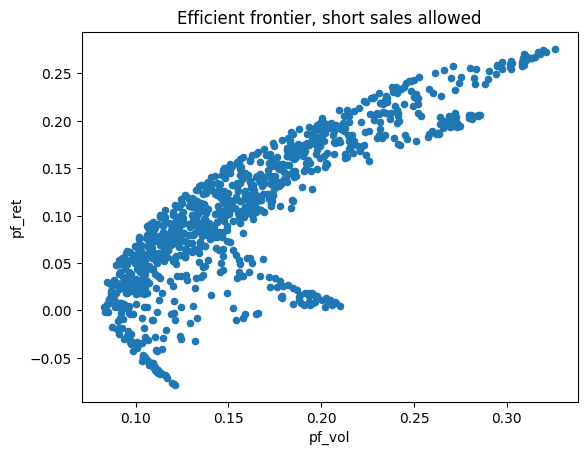

In [10]:
pf = PortfolioOpt(['.SPX', 'AAPL.O', 'MSFT.O', 'EUR=', 'XAU='])
# Simulate 1000 random portfolios
op = pf.sim_random(1000, return_alloc=True)
plt.title("Efficient frontier, short sales allowed");

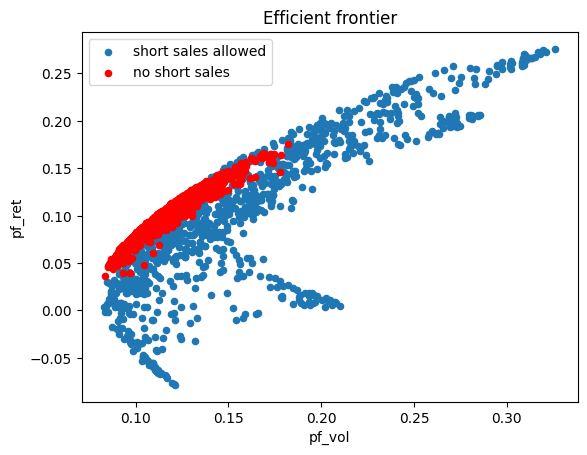

In [11]:
# Compare with no short sales
pf2 = PortfolioOpt(['.SPX', 'AAPL.O', 'MSFT.O', 'EUR=', 'XAU='], short_sales_allowed=False)
op2 = pf2.sim_random(1000, return_alloc=True, show_plot=False)
ax = op.plot.scatter(x='pf_vol', y='pf_ret', title='Efficient frontier')
op2.plot.scatter(x='pf_vol', y='pf_ret', ax=ax, c='r')
plt.legend(['short sales allowed', 'no short sales'])

In [12]:
# Calculate min vol and max sharpe portfolio
minvol_pf_5p = pf.opt_minvol((0.05, 1))
maxsharpe_pf_5p = pf.opt_maxsharpe((0.05, 1))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x wer

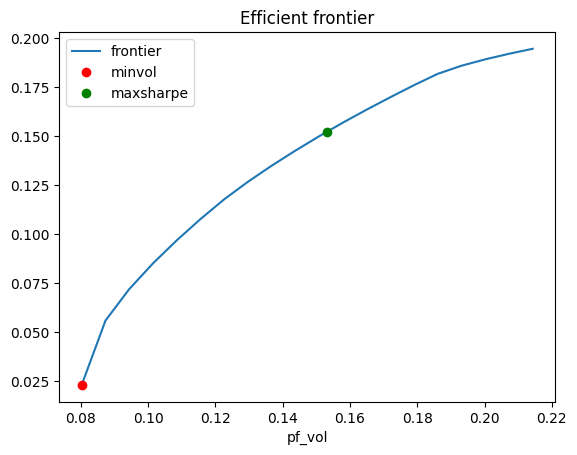

In [13]:
# Plot efficient frontier
frontier = pf.plot_efficient_frontier((0.05, 1))
plt.plot(*pf.calc_stats(minvol_pf_5p)[['pf_std', 'pf_ret']], "or")
plt.plot(*pf.calc_stats(maxsharpe_pf_5p)[['pf_std', 'pf_ret']], "og")
plt.legend(['frontier', 'minvol', 'maxsharpe'])

## Tools & Skills

**Lightweight Tool Chain**

Create a DigitalOcean Droplet. Install Miniconda on it.

Install the lightweight tool chain `Screen + IPython + Vim + q` on the droplet.

Re-implement your favourite exercise(s) or test projects (e.g. those above) working via SSH on the Droplet.

Use the `doctest` and/or the `unittest` package to test your classes.

## Financial Data Science

**[REVIEW]**

## AI in Finance

**[REVIEW]**

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>